In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import json

code reference: https://nicobesser.medium.com/brownian-motion-and-monte-carlo-simulation-of-daily-stock-price-eb86cd3c236f

In [3]:
sectors = ["FSTA","FDIS","FENY","FIDU","FMAT","FUTY","FTEC","FCOM","FNCL","FHLC","FREL"]

In [4]:
def get_data(sectors,start_date = datetime.strptime('01/01/19','%d/%m/%y')):
    df = pd.DataFrame([])
    for sector in sectors:
        df[sector] = yf.download(sector,start=start_date) ["Adj Close"]
    return df

In [5]:
df = get_data(sectors)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
df = df.groupby([pd.Grouper(freq='M')]).mean()

In [21]:
def log(df):
    df_logged = np.log(df).diff().dropna()
    return df_logged
    

In [9]:
df_logged = log(df)

In [11]:
def simluate_init(df_logged,sim_count = 5,period = 100):
    S_init = df_logged.iloc[[-1]].values[0]
    
    mu = df_logged.mean()
    var = df_logged.var()
    drift = mu - (0.5*var)
    desvest = df_logged.std()
    n_simulations = sim_count
    days = np.arange(period)
    
    return S_init,mu,var,drift,desvest,n_simulations,days

In [12]:
def simulate(S0,drift, desvest, days,n_simulations,mu):
    epsilon = norm.ppf(np.random.rand(len(days), n_simulations))
    returns =  drift + desvest * epsilon
    expected_returns = np.zeros(len(days))

    
    S = np.zeros_like(returns)
    S[0] = S0
    expected_returns[0] = S0
    
    for t in range(1, len(days)):
#         print(np.exp(returns[t])).
        S[t] = S[t-1]*np.exp(returns[t])
        expected_returns[t] = expected_returns[t-1]*np.exp(mu)
    return S,expected_returns

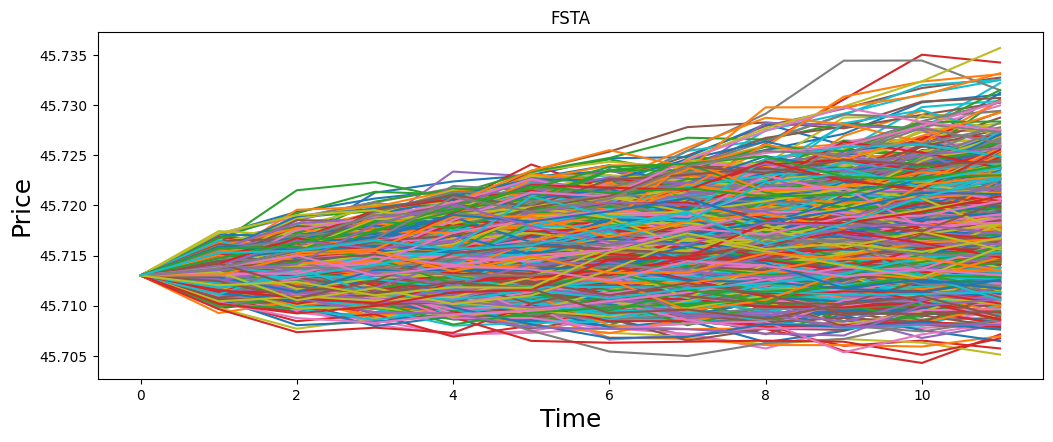

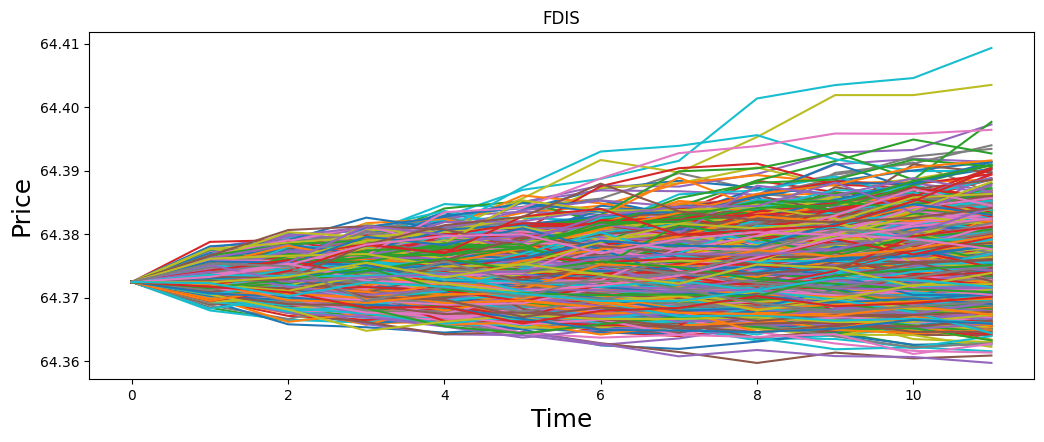

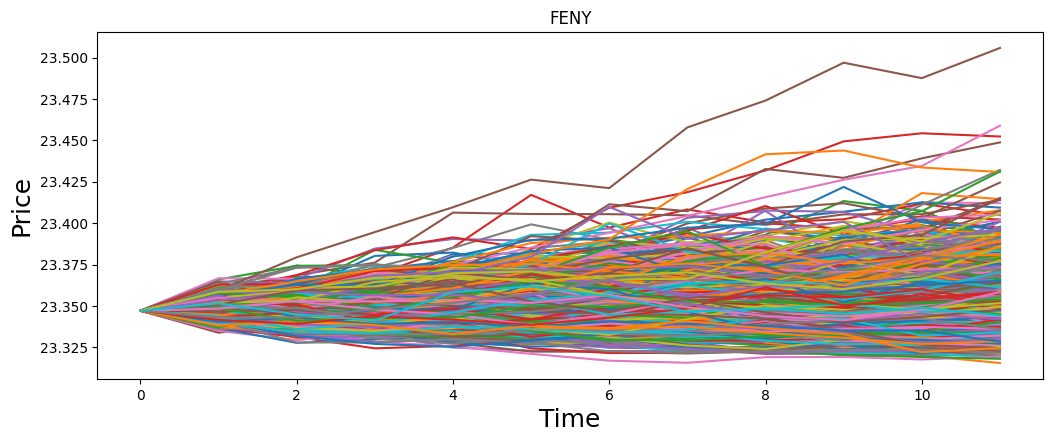

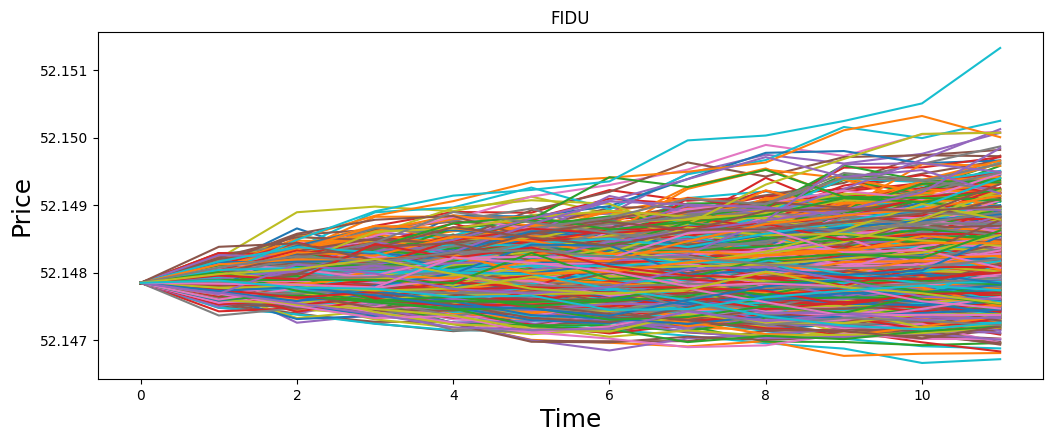

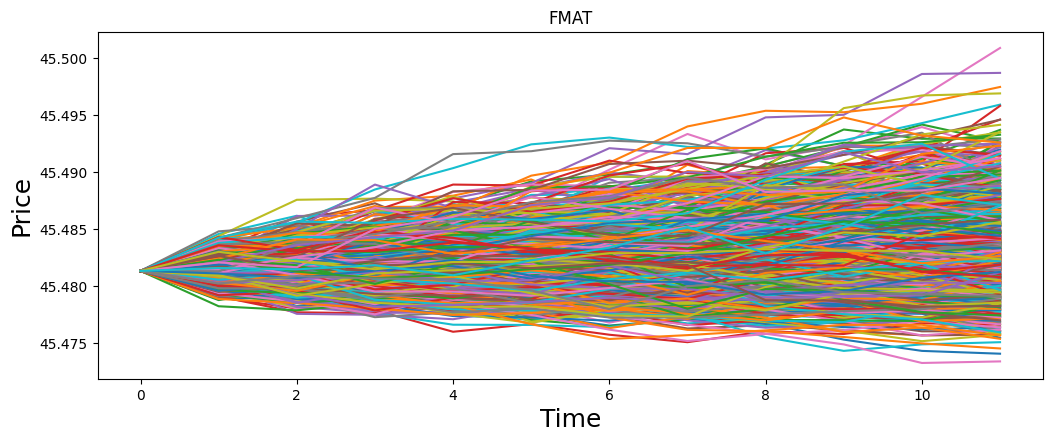

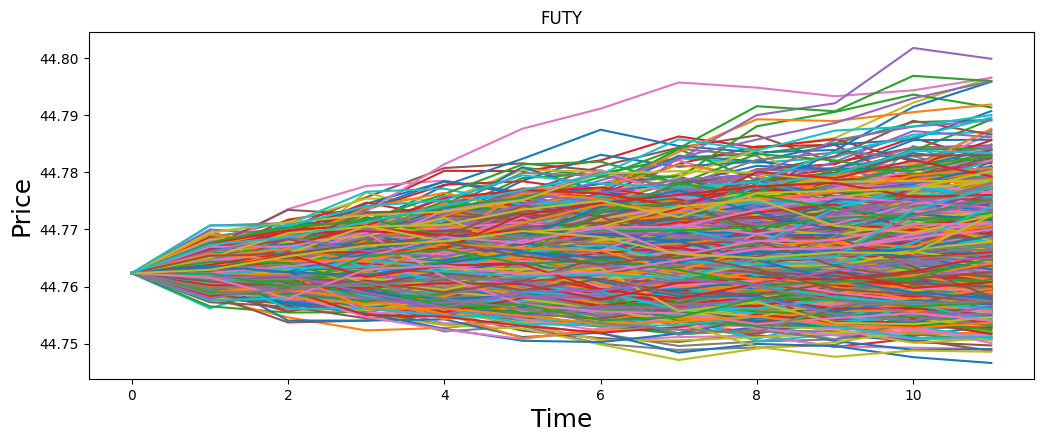

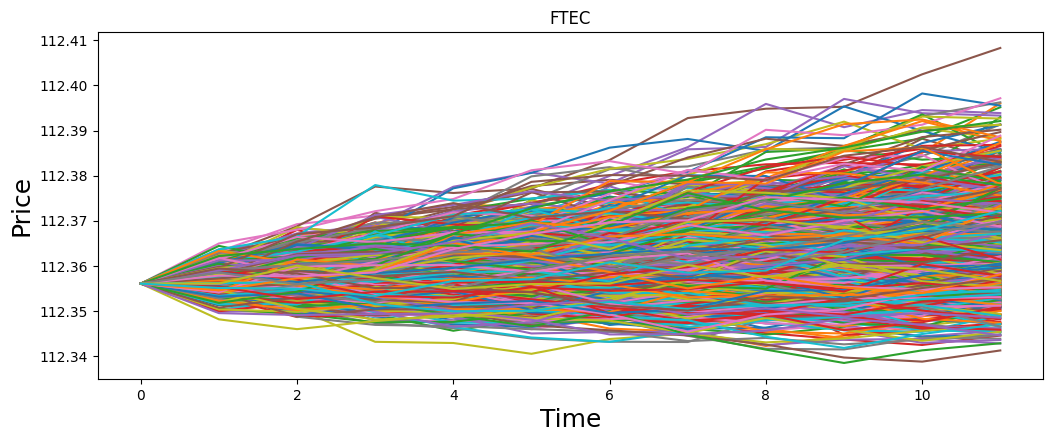

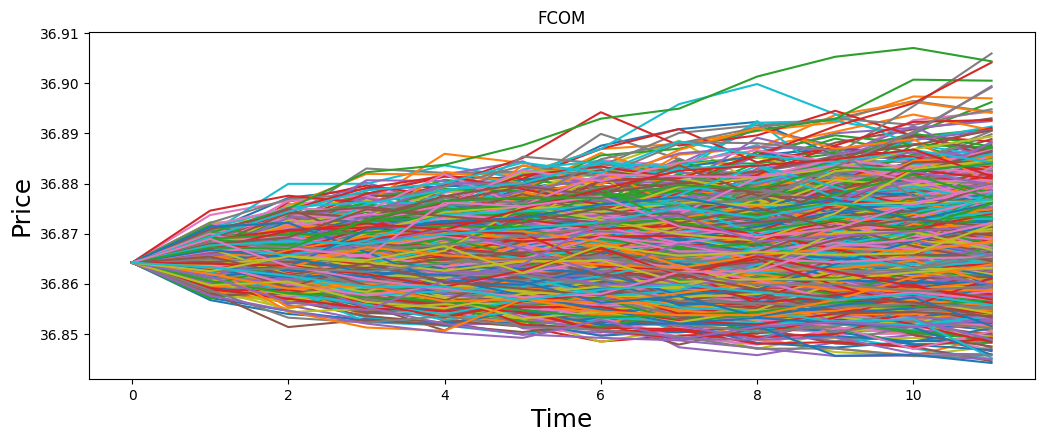

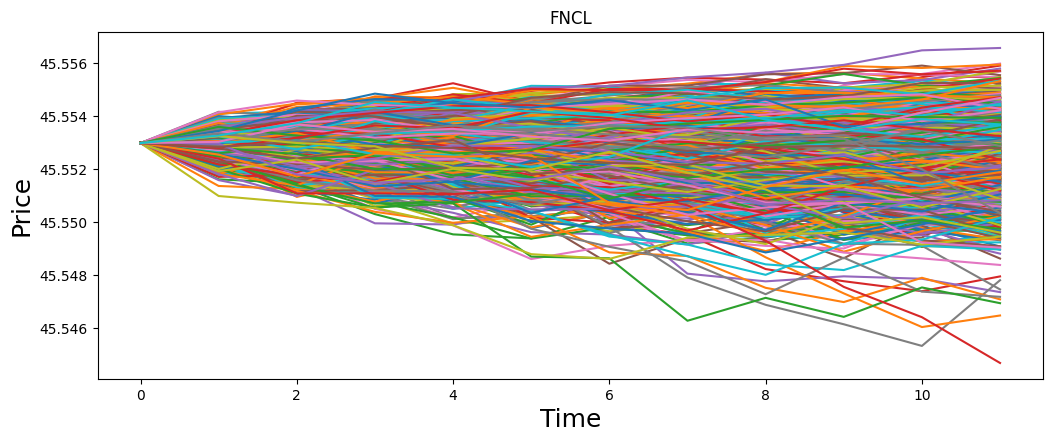

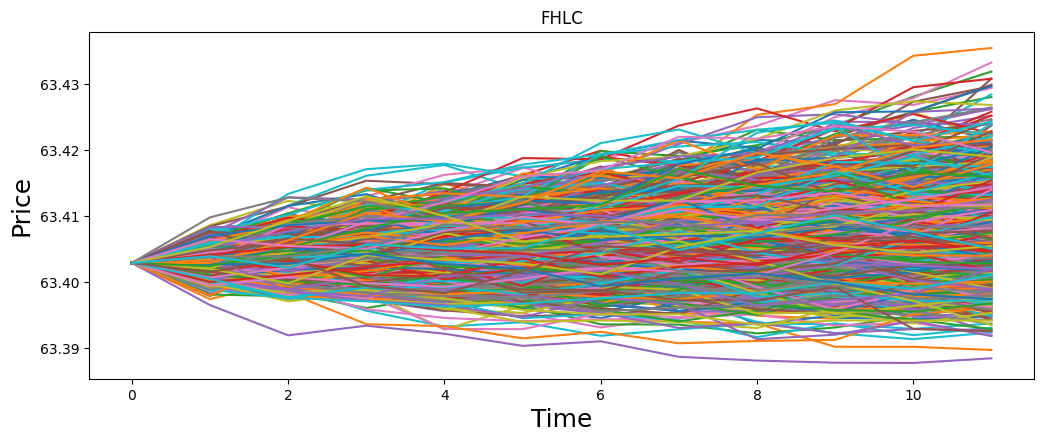

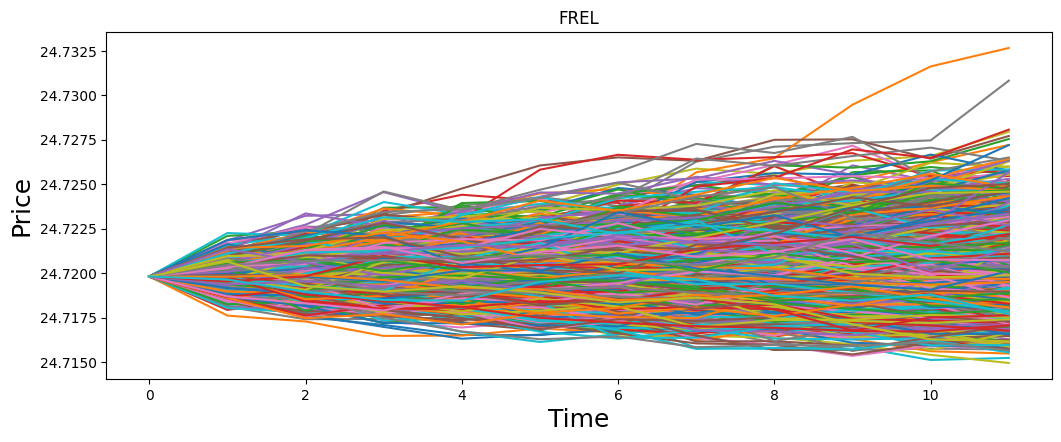

In [13]:
S_all = []
expected_returns_all = []
S_prices = []
S_init,mu,var,drift,desvest,n_simulations,days =  simluate_init(df_logged,sim_count = 1000,period = 12)
for idx in range(len(sectors)):
    S,expected_returns = simulate(S_init[idx],drift[idx],desvest.values[idx],days,n_simulations,mu[idx])
    S_all.append(S)
    S_prices.append(np.asarray(S)+df[sectors[idx]][-1:][0])
    expected_returns_all.append(expected_returns)
    plt.figure(figsize=(12.2,4.5))
    plt.plot(S_prices[idx])
#     plt.plot(expected_returns)
    plt.title(sectors[idx])
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Price',fontsize=18)
    plt.show()

In [16]:
variance = []
for S in S_all:
    variance.append(S[11].std())

In [18]:
json_variances = json.dumps(dict(zip(sectors,variance)))
with open("json_variances.json", "w") as outfile:
    outfile.write(json_variances)